In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv 
import scipy
from distmesh import *

count =  200 displacement =  0.011759075172717093
count =  400 displacement =  0.006768744864205259
count =  600 displacement =  0.006483390800013377
count =  800 displacement =  0.0045685641723632806


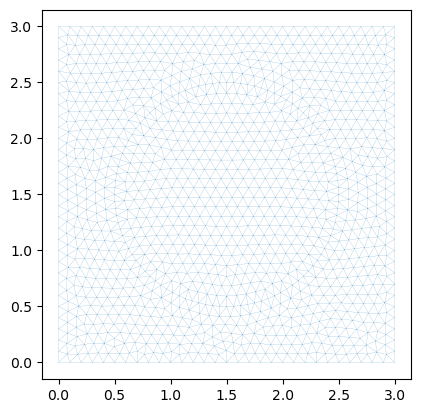

In [2]:
n = 31
t = np.linspace(0,3,n)

def dfunc(p):
    d0 = drectangle(p, 0, 3, 0, 3)
#     d1 = dcircle(p, 0, 0, 1)
#     d = ddiff(d0, d1)
    return d0

pos3_column = np.full_like(t, 3)
zero_column = np.full_like(t , 0)
top_line = np.column_stack((t, pos3_column))
bot_line = np.column_stack((t, zero_column))
right_line = np.column_stack((pos3_column, t))
left_line = np.column_stack((zero_column, t))

nt = 100
tt = np.linspace(0, 2*np.pi*(nt/(nt+1)), nt)
in_circle = np.concatenate((np.reshape(np.cos(tt)+1.5,(nt,1)),np.reshape(np.sin(tt)+1.5,(nt,1))),axis = 1)

pfix = np.concatenate((bot_line, left_line[1:-1], top_line, right_line[1:-1], in_circle), axis = 0)

h0 = 0.1

xmin = 0
xmax = 3
ymin = 0
ymax = 3

bbox = [xmin,xmax,ymin,ymax] # the bounding box

pts,tri = distmesh2D(dfunc,huniform,h0,bbox,pfix)

In [3]:
print(pts.shape)

(1239, 2)


In [4]:
print(tri.shape)

(2356, 3)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
[1208 1209 1210 1211 1212 1213 1214 1215 1216 1217 1218 1219 1220 1221
 1222 1223 1224 1225 1226 1227 1228 1229 1230 1231 1232 1233 1234 1235
 1236 1237 1238]


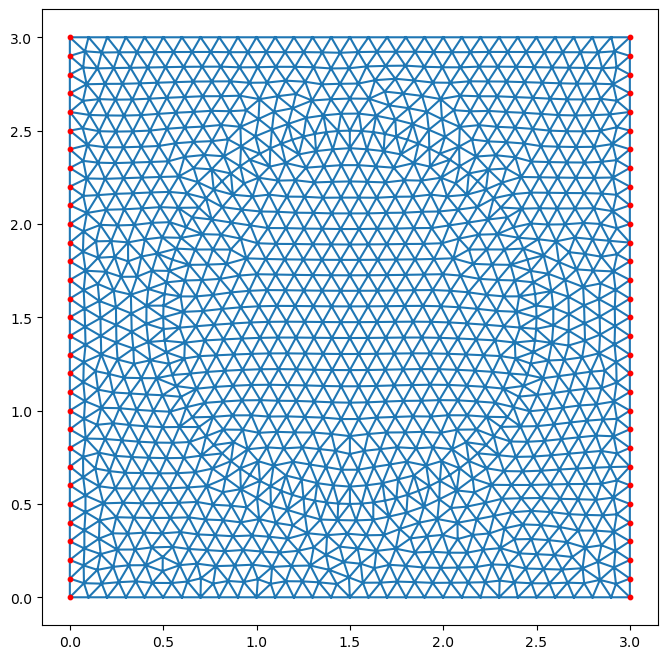

In [5]:
# find indices of mesh points on the Dirichlet boundary
left_boundary_index = []
right_boundary_index = []
for i in range(len(pts)):
    if pts[i][0] == 0:
        left_boundary_index.append(i)
    elif pts[i][0] == 3:
        right_boundary_index.append(i)

left_boundary_index = np.asarray(left_boundary_index)
right_boundary_index = np.asarray(right_boundary_index)
        
print(left_boundary_index)
print(right_boundary_index)

dirichlet_bdry = np.concatenate((left_boundary_index,right_boundary_index))

plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize = (8,8))
plt.triplot(pts[:,0],pts[:,1],tri)    
plt.scatter(pts[dirichlet_bdry,0],pts[dirichlet_bdry,1],s=10,c="red")  
ax.set_aspect('equal')

[   0   61   98  136  174  215  258  298  337  377  416  458  498  535
  575  619  661  700  738  778  819  858  898  936  978 1021 1062 1100
 1138 1176 1208]
[  30   62   99  137  175  216  259  299  338  378  417  459  499  536
  576  620  662  701  739  779  820  859  899  937  979 1023 1063 1101
 1139 1177 1238]


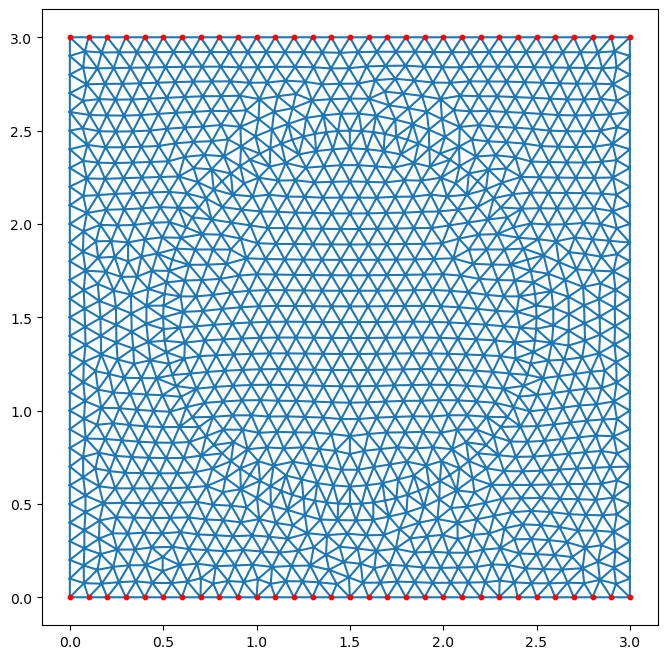

In [6]:
top_boundary_index = []
bot_boundary_index = []
for i in range(len(pts)):
    if pts[i][1] == 0:
        bot_boundary_index.append(i)
    elif pts[i][1] == 3:
        top_boundary_index.append(i)

bot_boundary_index = np.asarray(bot_boundary_index)
top_boundary_index = np.asarray(top_boundary_index)
        
print(bot_boundary_index)
print(top_boundary_index)

neumann_bdry = np.concatenate((bot_boundary_index,top_boundary_index))

plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize = (8,8))
plt.triplot(pts[:,0],pts[:,1],tri)    
plt.scatter(pts[neumann_bdry,0],pts[neumann_bdry,1],s=10,c="red")  
ax.set_aspect('equal')

In [7]:
# define finite element functions
def stima3(verts):
    Aux = np.ones((3,3))
    Aux[1:3,:] = np.transpose(verts)
    rhs = np.zeros((3,2))
    rhs[1,0] = 1
    rhs[2,1] = 1
    G = np.zeros((3,2))
    G[:,0] = np.linalg.solve(Aux,rhs[:,0])
    G[:,1] = np.linalg.solve(Aux,rhs[:,1])
    M = 0.5*np.linalg.det(Aux)*np.matmul(G,np.transpose(G))
    return M

In [8]:
# FEM
Npts = np.size(pts,axis=0) # the number of mesh points
Ntri = np.size(tri,axis=0) # the number of triangle
print("Npts = ",Npts," Ntri = ",Ntri)

Npts =  1239  Ntri =  2356


### Case (a): $a_{1} = 1.2, a_{2} = 1.0$

In [69]:
free_nodes = np.setdiff1d(np.arange(0,Npts,1,dtype = int),dirichlet_bdry,assume_unique=True)

A = scipy.sparse.csr_matrix((Npts,Npts), dtype = float).toarray() # define the sparse matrix A
b = np.zeros((Npts,1)) # the right-hand side
u = np.zeros((Npts,1)) # the solution
u[right_boundary_index] = 1 # define u at known values

a1 = 1.2
a2 = 1.0

# stiffness matrix
for j in range(Ntri):
    v = pts[tri[j,:],:] # vertices of mesh triangle
    ind = tri[j,:]
    indt = np.array(ind)[:,None]
    conductivity = a1 if (np.sqrt((np.mean(v[:, 0])-1.5)**2 + (np.mean(v[:, 1])-1.5)**2)) < 1 else a2
#     B = scipy.sparse.csr_matrix((3,3),dtype = float).toarray()
    A[indt,ind] += stima3(v)*conductivity

# load vector
b = b - np.matmul(A,u)


# solve for committor
free_nodes_t = np.array(free_nodes)[:,None]
u[free_nodes] = scipy.linalg.solve(A[free_nodes_t,free_nodes],b[free_nodes])
u = np.reshape(u,(Npts,))

Text(0.5, 1.0, 'Voltage $a_1=1.2,\\ a_2=1.0$')

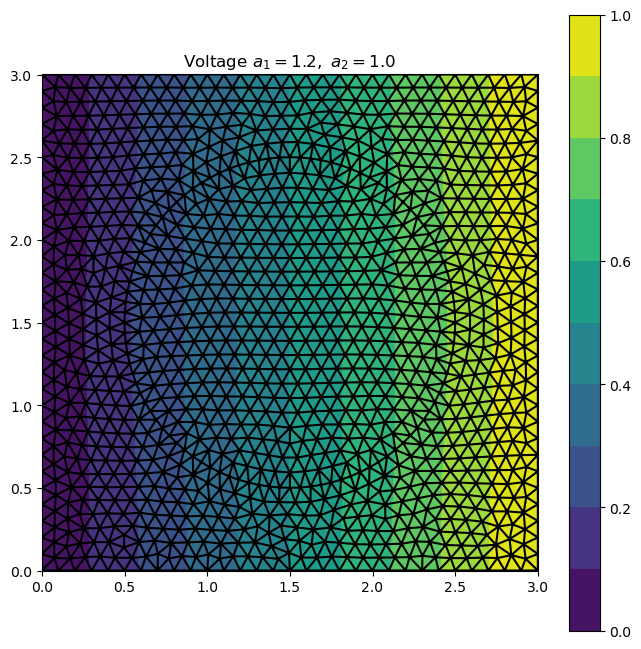

In [70]:
# visualization
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize = (8,8))
plt.tricontourf(pts[:,0], pts[:,1],tri,u,np.arange(0,1.1,0.1))
plt.colorbar()
ax.set_aspect('equal')
ax.set(xlim=(0,3), ylim=(0,3)) 

plt.triplot(pts[:,0],pts[:,1],tri, color='black')
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 10})
plt.title(r'Voltage $a_1=1.2,\ a_2=1.0$')

In [71]:
def grad_u(v, u):
    u1, u2, u3 = v[0], v[1], v[2]
    cons = 1 / (u1[0]*u2[1]+u2[0]*u3[1]+u3[0]*u1[1]-u1[0]*u3[1]-u2[0]*u1[1]-u3[0]*u2[1])
    grad_eta1 = np.array([(u2[1]-u3[1]), (u3[0]-u2[0])]) * cons
    grad_eta2 = np.array([(u3[1]-u1[1]), (u1[0]-u3[0])]) * cons
    grad_eta3 = np.array([(u1[1]-u2[1]), (u2[0]-u1[0])]) * cons
    
#     center = np.array([np.mean((u1[0], u2[0], u3[0])), np.mean((u1[1], u2[1], u3[1]))])

    return np.dot(u[0], grad_eta1) + np.dot(u[1], grad_eta2) + np.dot(u[2], grad_eta3)
#     return np.dot(center, grad_eta1+grad_eta2+grad_eta3)

In [72]:
abs_current_verts = np.zeros(Npts)
count_tri = np.zeros(Npts)

for j in range(Ntri):    
#     abs_current_verts[tri[j,:]] += abs_current_centers[j]
    v = pts[tri[j,:],:]
    ind = tri[j,:]
#     indt = np.array(ind)[:,None]
    
    conductivity = a1 if (np.sqrt((np.mean(v[:, 0])-1.5)**2 + (np.mean(v[:, 1])-1.5)**2)) < 1 else a2
    abs_current_verts[tri[j,:]] += np.linalg.norm(grad_u(v, u[ind]) * conductivity)
    count_tri[tri[j,:]] += 1

# Avoid division by zero
count_tri[count_tri == 0] = 1
abs_current_verts /= count_tri

Text(0.5, 1.0, 'Absolute Current Density $a_1=1.2,\\ a_2=1.0$')

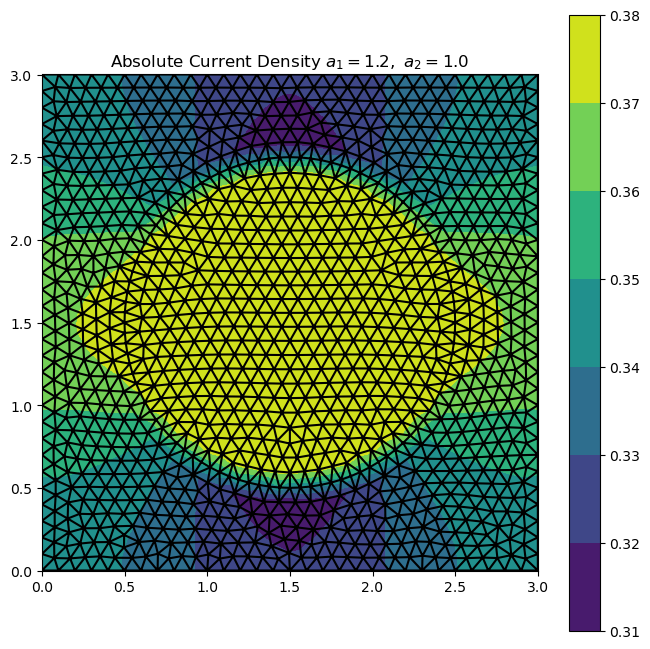

In [73]:
# visualization
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize = (8,8))
plt.tricontourf(pts[:,0], pts[:,1],tri,abs_current_verts)
plt.colorbar()
ax.set_aspect('equal')
ax.set(xlim=(0,3), ylim=(0,3)) 

plt.triplot(pts[:,0],pts[:,1],tri, color='black')
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 10})
plt.title(r'Absolute Current Density $a_1=1.2,\ a_2=1.0$')

### Case (a): $a_{1} = 0.8, a_{2} = 1.0$

In [74]:
free_nodes = np.setdiff1d(np.arange(0,Npts,1,dtype = int),dirichlet_bdry,assume_unique=True)

A = scipy.sparse.csr_matrix((Npts,Npts), dtype = float).toarray() # define the sparse matrix A
b = np.zeros((Npts,1)) # the right-hand side
u = np.zeros((Npts,1)) # the solution
u[right_boundary_index] = 1 # define u at known values

a1 = 0.8
a2 = 1.0

# stiffness matrix
for j in range(Ntri):
    v = pts[tri[j,:],:] # vertices of mesh triangle
    ind = tri[j,:]
    indt = np.array(ind)[:,None]
    conductivity = a1 if (np.sqrt((np.mean(v[:, 0])-1.5)**2 + (np.mean(v[:, 1])-1.5)**2)) < 1 else a2
#     B = scipy.sparse.csr_matrix((3,3),dtype = float).toarray()
    A[indt,ind] += stima3(v)*conductivity

# load vector
b = b - np.matmul(A,u)


# solve for committor
free_nodes_t = np.array(free_nodes)[:,None]
u[free_nodes] = scipy.linalg.solve(A[free_nodes_t,free_nodes],b[free_nodes])
u = np.reshape(u,(Npts,))

Text(0.5, 1.0, 'Voltage $a_1=0.8,\\ a_2=1.0$')

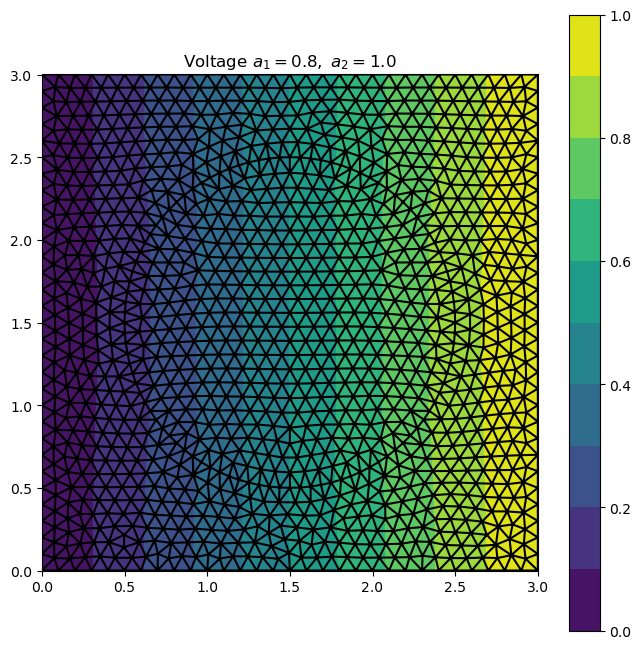

In [75]:
# visualization
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize = (8,8))
plt.tricontourf(pts[:,0], pts[:,1],tri,u,np.arange(0,1.1,0.1))
plt.colorbar()
ax.set_aspect('equal')
ax.set(xlim=(0,3), ylim=(0,3)) 

plt.triplot(pts[:,0],pts[:,1],tri, color='black')
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 10})
plt.title(r'Voltage $a_1=0.8,\ a_2=1.0$')

In [76]:
abs_current_verts = np.zeros(Npts)
count_tri = np.zeros(Npts)

for j in range(Ntri):    
#     abs_current_verts[tri[j,:]] += abs_current_centers[j]
    v = pts[tri[j,:],:]
    ind = tri[j,:]
#     indt = np.array(ind)[:,None]
    
    conductivity = a1 if (np.sqrt((np.mean(v[:, 0])-1.5)**2 + (np.mean(v[:, 1])-1.5)**2)) < 1 else a2
    abs_current_verts[tri[j,:]] += np.linalg.norm(grad_u(v, u[ind]) * conductivity)
    count_tri[tri[j,:]] += 1

# Avoid division by zero
count_tri[count_tri == 0] = 1
abs_current_verts /= count_tri

Text(0.5, 1.0, 'Absolute Current Density $a_1=0.8,\\ a_2=1.0$')

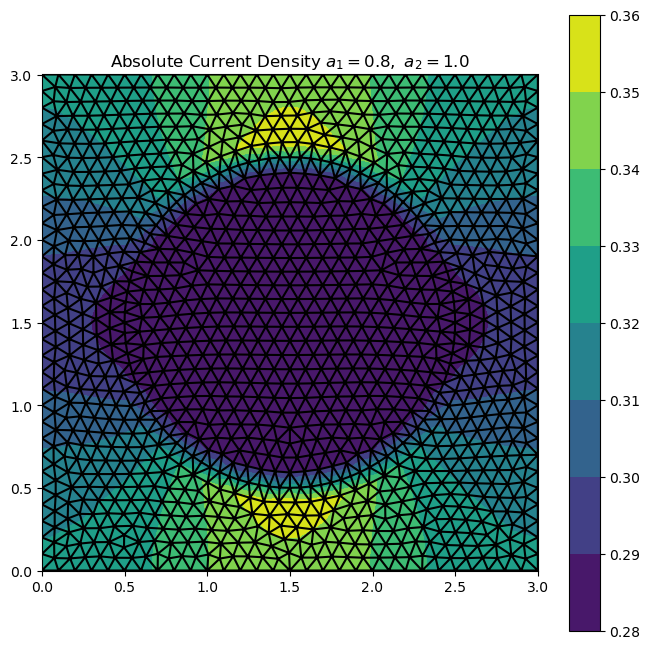

In [79]:
# visualization
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize = (8,8))
plt.tricontourf(pts[:,0], pts[:,1],tri,abs_current_verts)
plt.colorbar()
ax.set_aspect('equal')
ax.set(xlim=(0,3), ylim=(0,3)) 

plt.triplot(pts[:,0],pts[:,1],tri, color='black')
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 10})
plt.title(r'Absolute Current Density $a_1=0.8,\ a_2=1.0$')